In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Complete to the create a client to connect to the MongoDB server, assigns the "air-quality" 
# database to db, and assigned the "nairobi" connection to nairobi.

client=MongoClient(host="localhost",port=27017)
db=client['air-quality']
nairobi=db['nairobi']

In [3]:
# Change the wrangle function below so that it returns a Series of the resampled data instead of a DataFrame.

def wrangle(collection):
    results = collection.find(
        {"metadata.site": 29, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    # Read data into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outliers
    df = df[df["P2"] < 500]

    # Resample to 1hr window
    y = df["P2"].resample("1H").mean().fillna(method='ffill')

    return y

In [4]:
# Use your wrangle function to read the data from the nairobi collection into the Series y.
y = wrangle(nairobi)
y.head()

timestamp
2018-11-01 16:00:00+03:00    22.170000
2018-11-01 17:00:00+03:00    25.621667
2018-11-01 18:00:00+03:00    26.746667
2018-11-01 19:00:00+03:00    25.840000
2018-11-01 20:00:00+03:00    21.888333
Freq: h, Name: P2, dtype: float64

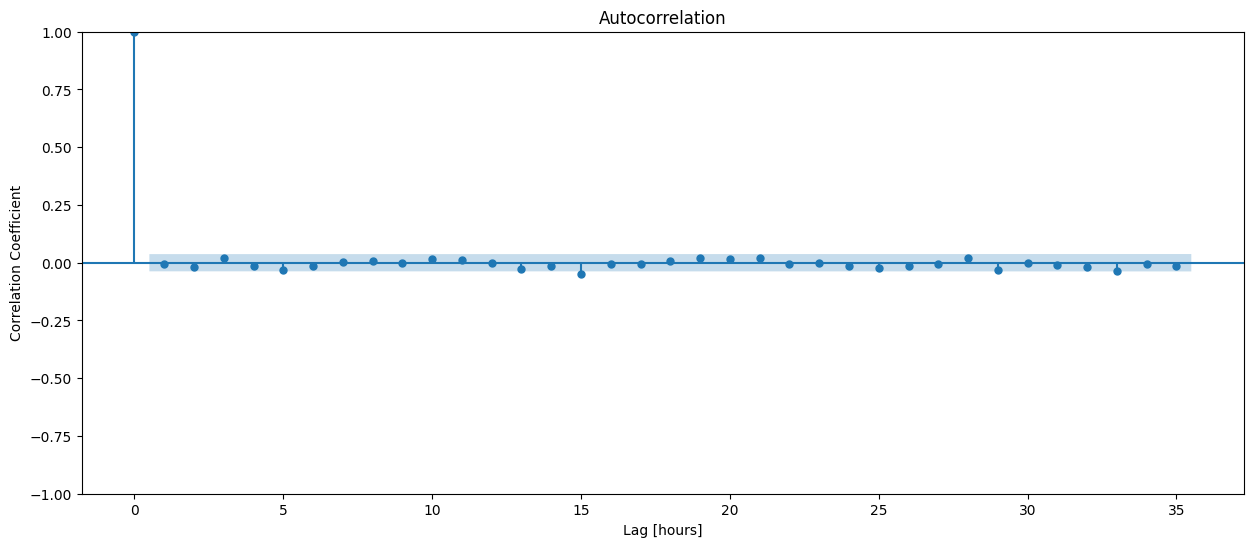

In [5]:
#Create an ACF plot for the data in y. Be sure to label the x-axis as "Lag [hours]" 
# and the y-axis as "Correlation Coefficient".

fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");



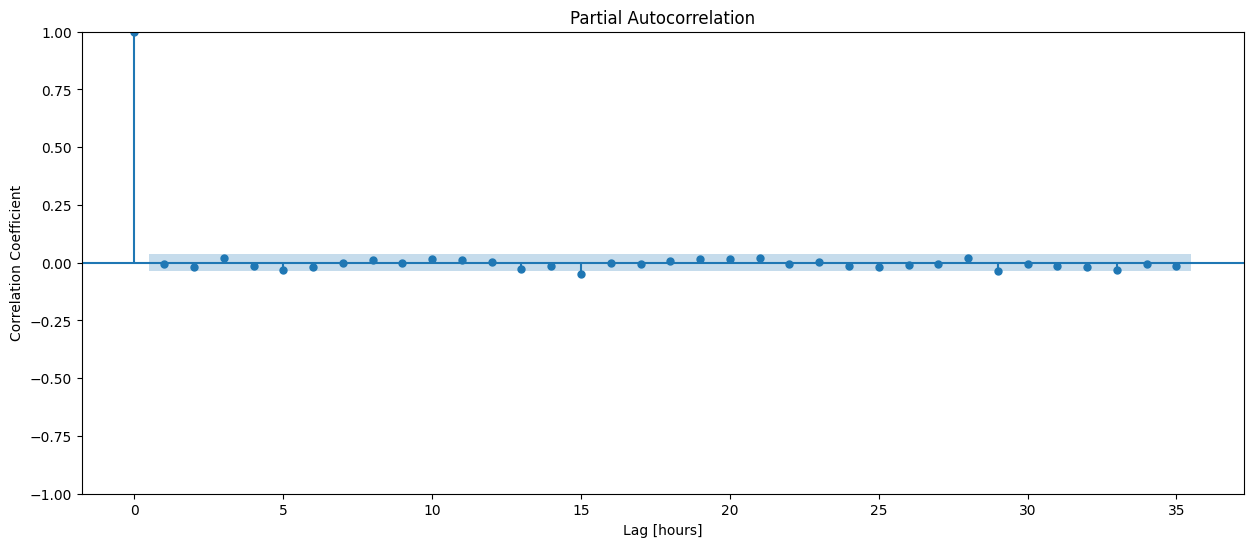

In [6]:
#Create an PACF plot for the data in y. Be sure to label the x-axis as "Lag [hours]" 
# and the y-axis as "Correlation Coefficient".
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [7]:
# Split y into training and test sets. The first 95% of the data should be in your training set. 
# The remaining 5% should be in the test set.
cutoff_test = int(len(y)*.95)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
# len(y)==len(y_test)+len(y_train)

In [8]:
# Calculate the baseline mean absolute error for your model.
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 25.04
Baseline MAE: 2.01


In [9]:
# Instantiate an AutoReg model and fit it to the training data y_train. 
# Be sure to set the lags argument to 26.
model = AutoReg(y_train,lags=26).fit()

In [10]:
# Generate a list of training predictions for your model and use them to calculate your training mean absolute error.
#model.predict().isnull().sum()
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train[26:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 1.9919576258423903


In [11]:
# Use y_train and y_pred to calculate the residuals for your model.
#y_train_resid = y_train-y_pred
y_train_resid = model.resid
y_train_resid.tail()

timestamp
2019-02-18 23:00:00+03:00   -0.128147
2019-02-19 00:00:00+03:00   -0.615472
2019-02-19 01:00:00+03:00   -4.349114
2019-02-19 02:00:00+03:00    2.290123
2019-02-19 03:00:00+03:00    1.617926
Freq: h, dtype: float64

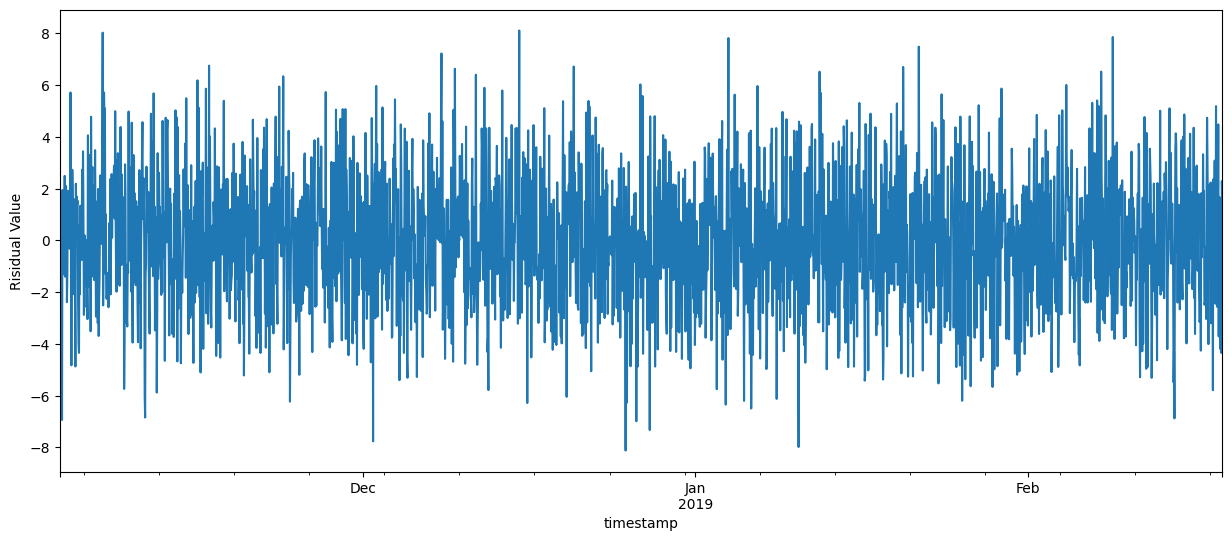

In [12]:
# Create a plot of y_train_resid.
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Risidual Value",ax=ax);

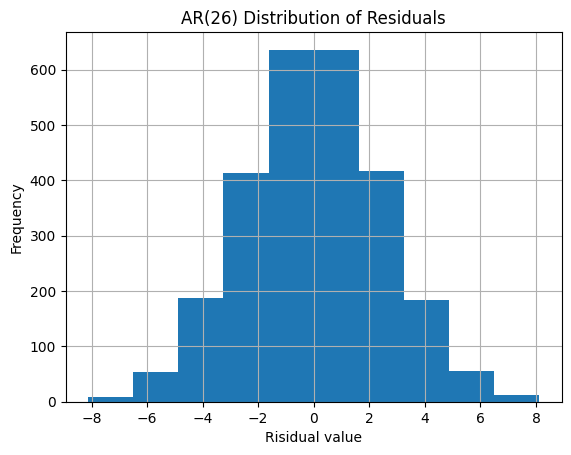

In [13]:
# Create a histogram of y_train_resid.
y_train_resid.hist()
plt.xlabel("Risidual value")
plt.ylabel("Frequency")
plt.title("AR(26) Distribution of Residuals");

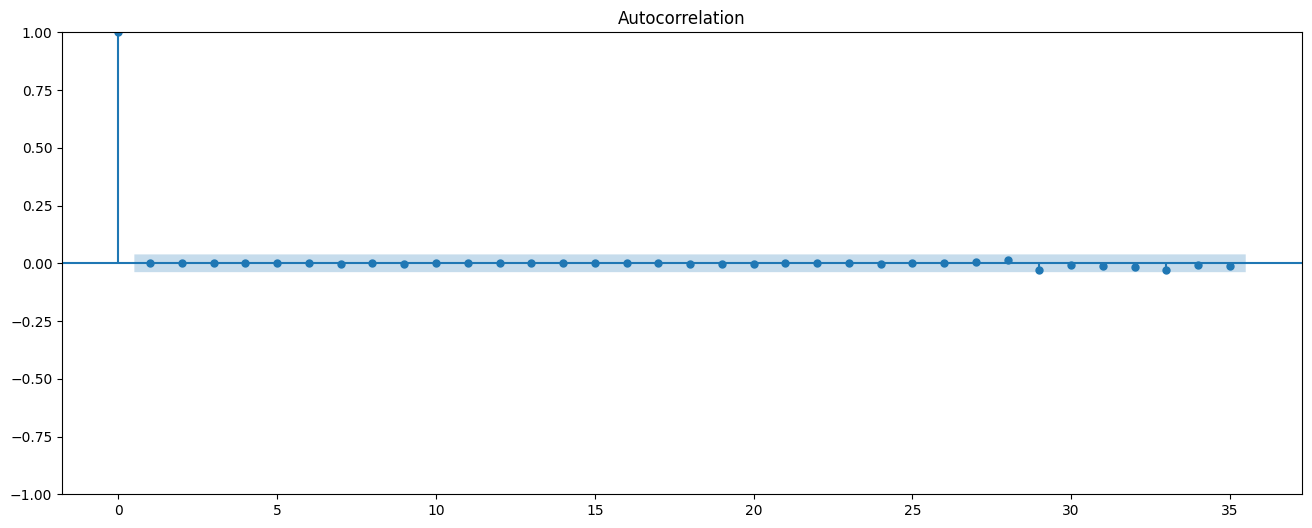

In [14]:
# Create an ACF plot of y_train_resid.
fig,ax=plt.subplots(figsize=(16,6))
plot_acf(y_train_resid,ax=ax);

In [15]:
# Calculate the test mean absolute error for your model.
#y_test.index.min()
#y_test.index.max()

y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 1.7948632222067873


In [16]:
# Create a DataFrame test_predictions that has two columns: "y_test" and "y_pred". 
# The first should contain the true values for your test set, and the second should 
# contain your model's predictions. Be sure the index of test_predictions matches 
# the index of y_test.

df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

In [17]:
# Create a time series plot for the values in test_predictions using plotly express.
# Be sure that the y-axis is properly labeled as "P2"
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

In [18]:
# Perform walk-forward validation for your model for the entire test set y_test. 
# Store your model's predictions in the Series y_pred_wfv.
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=26).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history=history.append(y_test[next_pred.index])    

UsageError: Line magic function `%%capture` not found.
